In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from collections import Counter
import datetime
import math
import random
try:
    import cPickle as pickle
except:
    import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.utils import multi_gpu_model
from livelossplot.inputs.tf_keras import PlotLossesCallback

In [2]:
column_names = ['path', 'make', 'model', 'year_of_production']
raw_dataset = pd.read_csv('./cars.csv', names = column_names, sep=';',
                      dtype={"path": str, "make": str, 'model': str, 'year_of_production': str})

raw_dataset = raw_dataset[raw_dataset.path != 'path']
raw_dataset = raw_dataset[raw_dataset.year_of_production != 'ints']

train_paths = raw_dataset['path'].values.tolist()
make = raw_dataset['make'].values.tolist()
model = raw_dataset['model'].values.tolist()
year = raw_dataset['year_of_production'].values.tolist()

CLASS_NAMES_MAKE = np.array(np.unique([name for name in make]))
CLASS_NAMES_MODEL = np.array(np.unique([name for name in model]))
CLASS_NAMES_YEAR = np.array(np.unique([name for name in year]))

BATCH_SIZE = 16
IMG_WIDTH = 220
IMG_HEIGHT = 220

image_count = len(train_paths)

STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)
STEPS_PER_EPOCH_TRAIN = np.ceil(image_count/BATCH_SIZE*0.8)
STEPS_PER_EPOCH_VAL = np.ceil(image_count/BATCH_SIZE*0.2)

In [3]:
os.chdir('Car_Dataset')

In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

path_list = tf.data.Dataset.from_tensor_slices(train_paths)

def get_label_make(labels):
    make = tf.strings.split(labels, '_')[0]
    return make == CLASS_NAMES_MAKE
def get_label_model(labels):
    pos = tf.strings.length(tf.strings.split(labels, '_')[0])+1
    length = tf.strings.length(labels)-pos-5
    model = tf.strings.substr(labels, pos, length)
    return model == CLASS_NAMES_MODEL
def get_label_year(labels):
    year = tf.strings.split(labels, '_')[-1]
    return year == CLASS_NAMES_YEAR

def decode_image(img):
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])


def process_dataset(file_path):
    labels = tf.strings.split(file_path, '/')[0]
    label_make = get_label_make(labels)
    label_model = get_label_model(labels)
    label_year = get_label_year(labels)
     
    img = tf.io.read_file(file_path)
    img = decode_image(img)
    return img, (label_make, label_model, label_year)

labeled_ds = path_list.map(process_dataset, num_parallel_calls=AUTOTUNE)

In [5]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [6]:
train_size = math.ceil(0.8 * image_count)
train_ds = labeled_ds.take(train_size)
val_ds = labeled_ds.skip(train_size)

In [7]:
train_set = prepare_for_training(train_ds)
val_set = prepare_for_training(val_ds)

In [8]:
image_input = keras.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3), name='input_image')
x = layers.Conv2D(32, (3, 3), activation='relu')(image_input)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(32, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)

output_make = layers.Dense(len(CLASS_NAMES_MAKE), activation='softmax', name='output_make')(x)
output_model = layers.Dense(len(CLASS_NAMES_MODEL), activation='softmax', name='output_model')(x)
output_year = layers.Dense(len(CLASS_NAMES_YEAR), activation='softmax', name='output_year')(x)

cnn = keras.Model(inputs=image_input, outputs=[output_make, output_model, output_year], name='cars_model')

In [9]:
cnn.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['acc'])

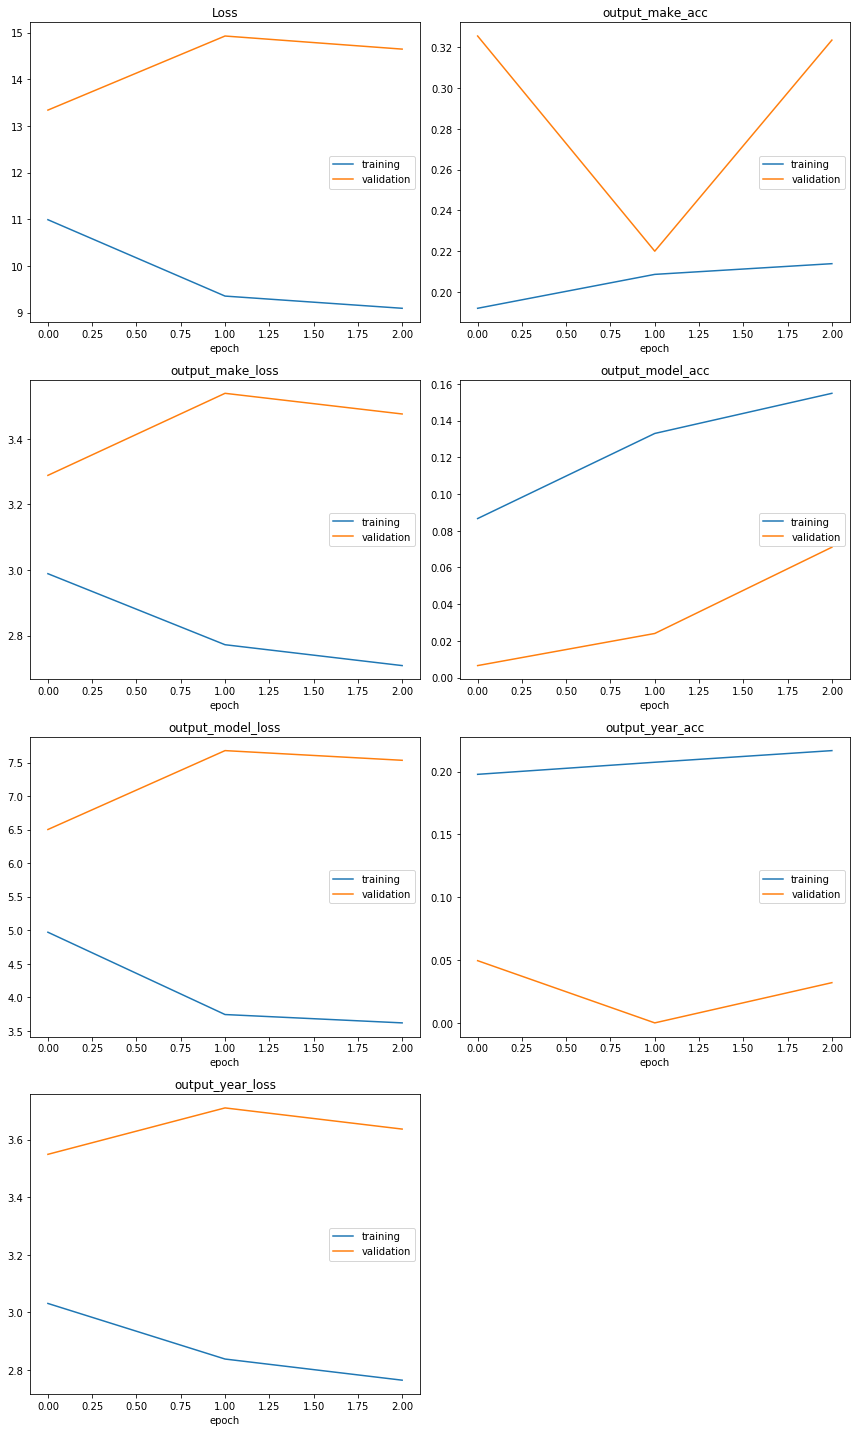

Loss
	training         	 (min:    9.091, max:   10.990, cur:    9.091)
	validation       	 (min:   13.340, max:   14.929, cur:   14.648)
output_make_acc
	training         	 (min:    0.192, max:    0.214, cur:    0.214)
	validation       	 (min:    0.220, max:    0.326, cur:    0.324)
output_make_loss
	training         	 (min:    2.708, max:    2.989, cur:    2.708)
	validation       	 (min:    3.289, max:    3.539, cur:    3.476)
output_model_acc
	training         	 (min:    0.087, max:    0.155, cur:    0.155)
	validation       	 (min:    0.007, max:    0.071, cur:    0.071)
output_model_loss
	training         	 (min:    3.617, max:    4.970, cur:    3.617)
	validation       	 (min:    6.502, max:    7.679, cur:    7.535)
output_year_acc
	training         	 (min:    0.198, max:    0.217, cur:    0.217)
	validation       	 (min:    0.000, max:    0.049, cur:    0.032)
output_year_loss
	training         	 (min:    2.765, max:    3.031, cur:    2.765)
	validation       	 (min:    3.549, 

KeyboardInterrupt: 

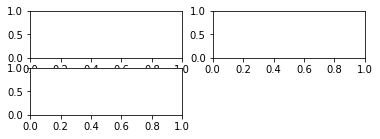

In [10]:
plot_losses = PlotLossesCallback()
cnn.fit(train_set,
        steps_per_epoch = STEPS_PER_EPOCH_TRAIN,
        epochs = 20,
        callbacks=[plot_losses],
        validation_data = val_set,
        validation_steps = STEPS_PER_EPOCH_VAL
        )